In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.spatial import distance
import xml.etree.ElementTree as ET
from shapely.geometry import Polygon, LineString
import pandas as pd
#from src.generate_traffic_data import clean_carla, spawn_scene, run_scene
import carla
import os
os.getcwd()
from datetime import datetime
import time
import random
from tqdm import tqdm
import networkx as nx
import numpy as np
import pickle

os.chdir('../..')
os.getcwd()


'/home/tmuehlen/repos/graph_coverage'

In [3]:
from graph_creator.MapGraph import MapGraph
from graph_creator.ActorGraph import ActorGraph

In [4]:
from graph_creator.plot_graphs import plot_lane_map_advanced, add_actors_to_map, add_actor_edges_to_map

In [ ]:
# client = carla.Client('localhost', 2000)
# client.set_timeout(10.0)
# world = client.get_world()
# world_map = world.get_map()

### Read map graph and tracks and try to create actor graph.

In [ ]:
# import pickle

# with open('/home/tmuehlen/repos/graph_coverage/data/actor_graph_argoverse.pkl', 'rb') as f:
#     ag = pickle.load(f)

# with open('/home/tmuehlen/repos/graph_coverage/data/map_argoverse.pkl', 'rb') as f:
#     map = pickle.load(f)

In [ ]:

#g = give_it_a_try.create_from_carla_map(world_map)
#g.store_graph_to_file('test.pickle')
#give_it_a_try.visualize_graph()
#g.visualize_graph()
# type(g)
# g.graph.nodes

In [5]:
files = os.listdir("/home/tmuehlen/repos/graph_coverage/carla/data")
scn_ids = [file.split("_")[1] for file in files if "tracks" in file]
scn_ids

['2025-08-30 22:23:13.009936',
 '2025-08-24 13:39:13.698326',
 '2025-08-24 13:09:53.255648',
 '2025-08-25 22:32:52.848707',
 '2025-08-25 22:17:26.441626',
 '2025-08-30 21:50:42.400301',
 '2025-08-30 22:08:30.926841',
 '2025-08-30 22:16:29.872627',
 '2025-08-25 22:15:25.146980',
 '2025-08-24 13:30:03.751131',
 '2025-08-30 21:46:28.006975',
 '2025-08-25 22:31:44.757262',
 '2025-08-30 22:26:55.620015',
 '2025-08-30 22:13:29.870307',
 '2025-08-27 22:42:35.846630',
 '2025-08-30 21:54:29.005142',
 '2025-08-24 13:43:23.995928',
 '2025-08-30 22:20:23.195071',
 '2025-08-30 22:28:18.847801',
 '2025-08-30 22:22:27.597921',
 '2025-08-30 22:25:07.988099',
 '2025-08-24 13:32:59.428368',
 '2025-08-24 13:26:57.295150',
 '2025-08-30 22:26:09.200293',
 '2025-08-27 22:37:11.487023',
 '2025-08-30 22:24:14.699788',
 '2025-08-25 22:13:36.453956',
 '2025-08-23 23:19:38.811319',
 '2025-08-30 22:18:25.433697',
 '2025-08-27 22:38:34.861141']

In [6]:
# run through all scens so far and create the graphs:

for scn_id in tqdm(scn_ids):
    g_map = MapGraph()
    g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_id}_map_graph.pickle')
    tracks = pd.read_parquet(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_id}_tracks.parquet')
    tracks['road_lane_id'] = tracks.road_id.astype(str) + '_' + tracks.lane_id.astype(str)
    timestamps = tracks.timestamp.unique().tolist()
    actors = tracks.actor_id.unique().tolist()
    ag = ActorGraph()
    ag_carla = ag.from_carla_scenario(tracks, 
        g_map, 
        max_distance_lead_veh_m=30, 
        max_distance_neighbor_forward_m=30, 
        max_distance_neighbor_backward_m=30, 
        max_distance_opposite_veh_m=30,
        )
    ag_carla.actor_graphs.keys()
    # clean up the graphs and components, i.e. remove components with only one node:
    keys = list(ag_carla.actor_graphs.keys())
    for  key in keys:
        ag_carla.actor_components[key] = [ag_carla.actor_components[key][i] for i in range(len(ag_carla.actor_components[key])) if ag_carla.actor_components[key][i].size() > 1]
    #pd.DataFrame(ag_carla.actor_graphs[5.5085996149573475].nodes(data=True)).iloc[0,1]
    ag_timestamps = list(ag_carla.actor_graphs.keys())
    timestamp_idx = 0
    component_idx = 0
    for timestamp_idx in range(len(ag_timestamps)):
        for component_idx in range(len(ag_carla.actor_components[ag_timestamps[timestamp_idx]])):
            save_path = f'/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/graph_{scn_id}_{timestamp_idx}_{component_idx}.pkl'
            with open(save_path, "wb") as file:
                pickle.dump(ag_carla.actor_components[ag_timestamps[timestamp_idx]][component_idx], file)



100%|██████████| 30/30 [11:04<00:00, 22.15s/it]


2025-08-27 22:38:34.861141


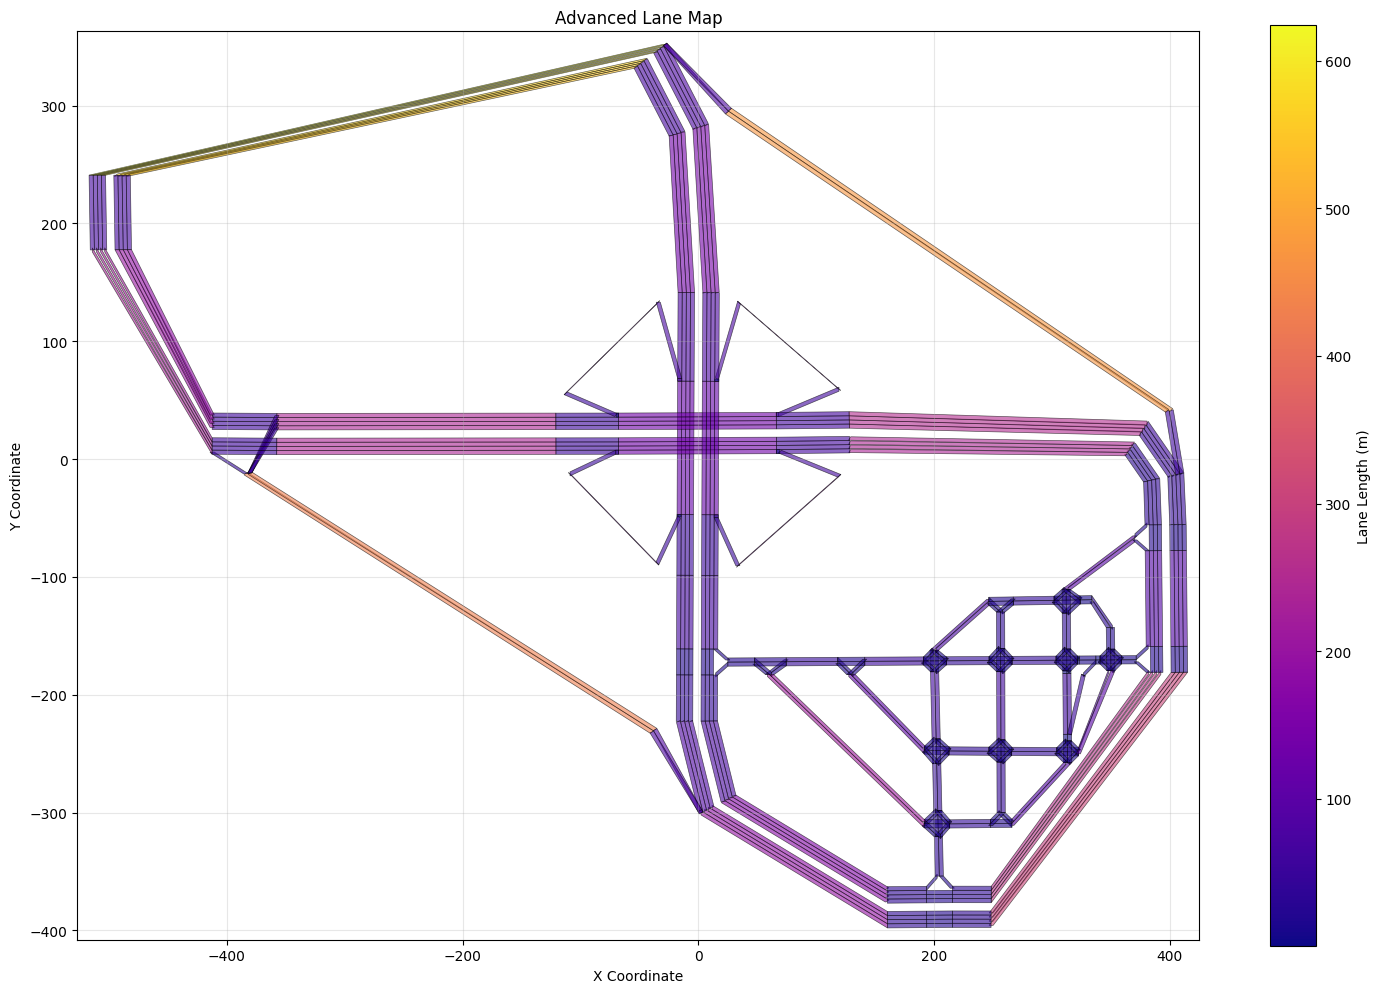

In [38]:
#scn_id = "2025-08-22 22:00:08.700981"
scn_id = "2025-08-23 23:19:38.811319"
scn_id = scn_ids[29]
print(scn_id)
g_map = MapGraph()
g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_id}_map_graph.pickle')
#g_map.visualize_graph()
fig, ax = plot_lane_map_advanced(g_map.graph, color_by_length=True, cmap='plasma', show_labels=False)
plt.show()


In [39]:
g_map.graph.nodes(data=True)

NodeDataView({'1602_-4': {'node_info': NodeInfo(lane_id='1602_-4', is_intersection=True, length=28.917706582695246, lane_polygon=<POLYGON ((377.987 -19.465, 361.827 3.888, 365.238 4.669, 381.399 -18.683, 3...>, left_boundary=None, right_boundary=None)}, '38_-4': {'node_info': NodeInfo(lane_id='38_-4', is_intersection=False, length=236.26366579532623, lane_polygon=<POLYGON ((362.566 2.82, 127.651 5.545, 129.584 8.462, 364.499 5.737, 362.56...>, left_boundary=None, right_boundary=None)}, '1602_-3': {'node_info': NodeInfo(lane_id='1602_-3', is_intersection=True, length=31.562646307051182, lane_polygon=<POLYGON ((381.399 -18.683, 363.76 6.805, 367.172 7.587, 384.811 -17.902, 38...>, left_boundary=None, right_boundary=None)}, '38_-3': {'node_info': NodeInfo(lane_id='38_-3', is_intersection=False, length=238.3553679138422, lane_polygon=<POLYGON ((364.499 5.737, 127.591 9.045, 129.524 11.962, 366.433 8.655, 364....>, left_boundary=None, right_boundary=None)}, '1602_-2': {'node_info': NodeInfo

In [40]:
pd.DataFrame(g_map.graph.nodes(data=True))
g_map.graph.nodes(data=True)
pd.DataFrame(g_map.graph.edges(data=True)).head(2)


,0,1,2
0,1602_-4,38_-4,{'edge_type': 'following'}
1,1602_-4,1602_-3,{'edge_type': 'neighbor'}


### load tracks data and do the actual actor graph creation

In [41]:
tracks = pd.read_parquet(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_id}_tracks.parquet')
tracks['road_lane_id'] = tracks.road_id.astype(str) + '_' + tracks.lane_id.astype(str)
print(tracks.shape)

timestamps = tracks.timestamp.unique().tolist()
actors = tracks.actor_id.unique().tolist()
tracks.head(2).T

(77700, 28)


,0,1
actor_id,505,504
actor_type,vehicle.audi.tt,vehicle.mercedes.coupe_2020
actor_speed_xyz,"[0.0, 0.0, -0.9800000786781311]","[0.0, 0.0, -0.9800000786781311]"
actor_acceleration_xyz,"[0.0, 0.0, -9.800002098083496]","[0.0, 0.0, -9.800002098083496]"
actor_location_xyz,"[-6.030386447906494, -119.45975494384766, 0.22...","[391.4577331542969, -66.31537628173828, 0.3461..."
actor_bbox,"[[-2.0909759998321533, -0.9970588088035583, 0....","[[-2.3394124507904053, -0.905925452709198, -0...."
distance_till_lane_end,20.594251,10.351717
distance_from_lane_start,41.25001,11.000002
t_per_lane_id,-0.000037,-0.000275
lane_id,3,-1


In [42]:
ag = ActorGraph()
ag_carla = ag.from_carla_scenario(tracks, 
    g_map, 
    max_distance_lead_veh_m=30, 
    max_distance_neighbor_forward_m=30, 
    max_distance_neighbor_backward_m=30, 
    max_distance_opposite_veh_m=30,
    )
ag_carla.actor_graphs.keys()


dict_keys([5.563109972747043, 6.563109987648204, 7.563110002549365, 8.563110017450526, 9.563110032351688, 10.563110047252849, 11.56311006215401, 12.563110077055171, 13.563110091956332, 14.563110106857494, 15.563110121758655, 16.563110136659816, 17.563110151560977, 18.56311016646214, 19.5631101813633, 20.513110195519403])

In [43]:
# clean up the graphs and components, i.e. remove components with only one node:
keys = list(ag_carla.actor_graphs.keys())
for  key in keys:
    ag_carla.actor_components[key] = [ag_carla.actor_components[key][i] for i in range(len(ag_carla.actor_components[key])) if ag_carla.actor_components[key][i].size() > 1]

#pd.DataFrame(ag_carla.actor_graphs[5.5085996149573475].nodes(data=True)).iloc[0,1]
ag_timestamps = list(ag_carla.actor_graphs.keys())
ag_carla.actor_graphs[ag_timestamps[0]].nodes(data=True)
ag_carla.actor_graphs[ag_timestamps[0]].edges(data=True)

OutMultiEdgeDataView([('503', '267', {'edge_type': 'following_lead', 'path_length': 19.09877946972847}), ('503', '430', {'edge_type': 'neighbor_vehicle', 'path_length': -30.459520041942596}), ('501', '277', {'edge_type': 'following_lead', 'path_length': 23.402755349874496}), ('501', '435', {'edge_type': 'neighbor_vehicle', 'path_length': -1.6449546366930008}), ('501', '496', {'edge_type': 'neighbor_vehicle', 'path_length': 21.664710372686386}), ('498', '478', {'edge_type': 'opposite_vehicle', 'path_length': -9.60001428425312}), ('497', '439', {'edge_type': 'neighbor_vehicle', 'path_length': -47.74998341500759}), ('497', '380', {'edge_type': 'neighbor_vehicle', 'path_length': 18.77999738417566}), ('497', '253', {'edge_type': 'neighbor_vehicle', 'path_length': 18.780004613101482}), ('496', '407', {'edge_type': 'following_lead', 'path_length': 19.45471791923046}), ('496', '451', {'edge_type': 'neighbor_vehicle', 'path_length': 1.8183797001838684}), ('496', '501', {'edge_type': 'neighbor_v

In [ ]:
# plot some results

# t_idx = ag_timestamps[0]
# print(t_idx)
# ag_carla.visualize_actor_graph(t_idx = t_idx, comp_idx = 0, use_map_pos=True, node_size = 100, graph_or_component='graph')
# for i in range(len(ag_carla.actor_components[t_idx])):
#     if ag_carla.actor_components[t_idx][i].size() > 1:
#         ag_carla.visualize_actor_graph(t_idx = t_idx, comp_idx = i, use_map_pos=True, node_size = 100, graph_or_component='component', scale_plot=False)


In [ ]:
ag_carla.actor_graphs[ag_timestamps[0]].nodes(data=True)
ag_carla.actor_graphs[ag_timestamps[0]].edges(data=True)


In [ ]:
# type(ag_carla.actor_components[ag_timestamps[0]][0])


# timestamp_idx = 0
# component_idx = 0

# for timestamp_idx in range(len(ag_timestamps)):
#     for component_idx in range(len(ag_carla.actor_components[ag_timestamps[timestamp_idx]])):
#         save_path = f'/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/graph_{scn_id}_{timestamp_idx}_{component_idx}.pkl'
#         with open(save_path, "wb") as file:
#             pickle.dump(ag_carla.actor_components[ag_timestamps[timestamp_idx]][component_idx], file)



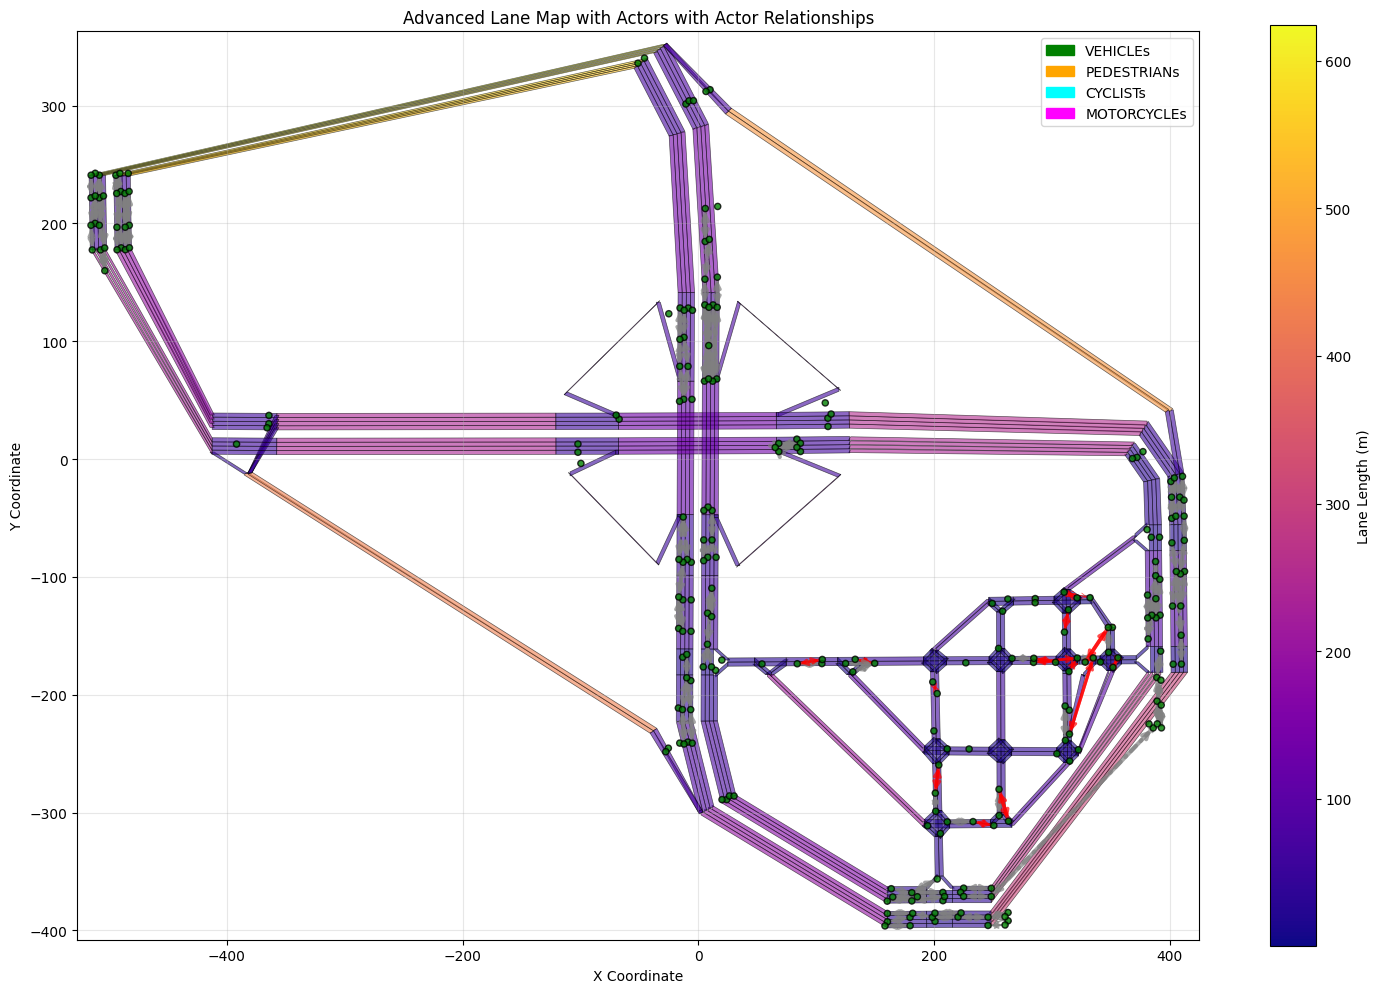

In [44]:
#  Step by step plotting
fig, ax = plot_lane_map_advanced(g_map.graph, color_by_length=True, cmap='plasma', show_labels=False)
fig, ax = add_actors_to_map(fig, ax, ag_carla.actor_graphs[ag_timestamps[0]], actor_size=20, show_actor_labels=False)
fig, ax = add_actor_edges_to_map(fig, ax, ag_carla.actor_graphs[ag_timestamps[0]])
plt.show()


### Create the timestepped graph:

In [ ]:
from graph_creator.ActorTimeGraph import ActorTimeGraph

ag_carla_time = ActorTimeGraph(ag_carla)
ag_carla_time.create_actor_time_graphs()

# clean up the graphs and components, i.e. remove components with only one node:
keys = list(ag_carla_time.actor_time_graphs.keys())
for  key in keys:
    ag_carla_time.actor_time_components[key] = [ag_carla_time.actor_time_components[key][i] for i in range(len(ag_carla_time.actor_time_components[key])) if ag_carla_time.actor_time_components[key][i].size() > 1]


In [ ]:
ag_carla_time.actor_time_components[ag_timestamps[5]][0].nodes(data=True)

In [ ]:
g_map.graph.nodes(data=True)
g_map.graph.edges(data=True)

### Start comparing graphs:

In [ ]:
t_idx = 24
t_idx = ag_timestamps[5]
comp_idx = 1
G1 = ag_carla.actor_components[t_idx][comp_idx]
ag_carla.visualize_actor_graph(t_idx = t_idx, comp_idx = comp_idx, use_map_pos=True, node_size = 100, graph_or_component='component')
t_idx = ag_timestamps[6]
comp_idx = 2
G2 = ag_carla.actor_components[t_idx][comp_idx]
ag_carla.visualize_actor_graph(t_idx = t_idx, comp_idx = comp_idx, use_map_pos=True, node_size = 100, graph_or_component='component')


In [ ]:
# node statistics:

print('degrees:', G1.degree())



In [ ]:
# graph statistics:
print('density: ', nx.density(G1))
print('diameter: ', nx.diameter(G1))
#print('clustering: ', nx.average_clustering(G))


### graph comparison:

In [ ]:
print('isomorphic:', nx.is_isomorphic(G1, G2)) # actually not meaningful, not what I understood
print('graph edit distsance:', nx.graph_edit_distance(G1, G2))
print('graph edit distsance similarity:', nx.algorithms.similarity.graph_edit_distance(G1, G2))


In [ ]:
GM = nx.algorithms.isomorphism.DiGraphMatcher(G1, G2)
print('isomorphic:', GM.is_isomorphic())
print('subgraph isomorphic:', GM.subgraph_is_isomorphic())

In [ ]:
GM = nx.algorithms.isomorphism.DiGraphMatcher(
    G1, G2,
    node_match=nx.algorithms.isomorphism.categorical_node_match('actor_type', None),
    edge_match=nx.algorithms.isomorphism.categorical_edge_match('edge_type', None)
)

print('isomorphic:', GM.is_isomorphic())
print('subgraph isomorphic:', GM.subgraph_is_isomorphic())

In [ ]:
G1.nodes(data=True)

### Define coverage categories in graphs:

In [ ]:
# most simple: follow lead vehicle:
G = nx.MultiDiGraph()
G.add_node(1, actor_type = 'vehicle')
G.add_node(2, actor_type='vehicle')
G.add_edge(1, 2, edge_type="leading_vehicle")
G.add_edge(2, 1, edge_type="following_lead")

In [ ]:
print(G.nodes(data=True))
print(G.edges(data=True))
print('')
print(G1.nodes(data=True))
print(G1.edges(data=True))
print('')
print(G2.nodes(data=True))
print(G2.edges(data=True))



In [ ]:
GM = nx.algorithms.isomorphism.DiGraphMatcher(
    G2, G,
    node_match=nx.algorithms.isomorphism.categorical_node_match('actor_type', None),
    edge_match=nx.algorithms.isomorphism.categorical_edge_match('edge_type', None)
)

print('isomorphic:', GM.is_isomorphic())
print('subgraph isomorphic:', GM.subgraph_is_isomorphic())

In [ ]:
GM = nx.algorithms.isomorphism.DiGraphMatcher(
    G1, G,
    #node_match=nx.algorithms.isomorphism.categorical_node_match('actor_type', None),
    edge_match=nx.algorithms.isomorphism.categorical_edge_match('edge_type', None)
)

print('isomorphic:', GM.is_isomorphic())
print('subgraph isomorphic:', GM.subgraph_is_isomorphic())

In [ ]:
GM = nx.algorithms.isomorphism.MultiDiGraphMatcher(
    G1, G,
    #node_match=nx.algorithms.isomorphism.categorical_node_match('actor_type', None),
    edge_match=nx.algorithms.isomorphism.categorical_edge_match('edge_type', None)
)

print('isomorphic:', GM.is_isomorphic())
print('subgraph isomorphic:', GM.subgraph_is_isomorphic())

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import isomorphism

# Step 1: Create the host graph G (Directed)
G = nx.DiGraph()
G.add_weighted_edges_from([
    ('A', 'B', 1),
    ('B', 'C', 2),
    ('C', 'D', 3),
    ('A', 'D', 4),
    ('D', 'E', 2),
    ('E', 'F', 1),
])

# Step 2: Create the pattern graph H (Subgraph we're looking for)
H = nx.DiGraph()
H.add_weighted_edges_from([
    ('X', 'Y', 2),
    ('Y', 'Z', 3),
])

# Step 3: Define the edge matcher based on 'weight'
edge_matcher = isomorphism.categorical_edge_match('weight', 0)

# Step 4: Create GraphMatcher with edge attributes
GM = isomorphism.DiGraphMatcher(G, H, edge_match=edge_matcher)

# Step 5: Visualization

# Draw the host graph G
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800, arrows=True)

# Label edge weights
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Highlight matched subgraphs
if GM.subgraph_is_isomorphic():
    print("✅ H is a subgraph of G!\n📌 Matching mappings:")
    for i, mapping in enumerate(GM.subgraph_isomorphisms_iter(), 1):
        print(f"Match {i}: {mapping}")
        
        # Extract edges from the match
        matched_edges = []
        #reverse_map = {v: k for k, v in mapping.items()}
        reverse_mapping = {v: k for k, v in mapping.items()}
        for u, v in H.edges():
            if u in reverse_mapping and v in reverse_mapping:
                source = reverse_mapping[u]
                target = reverse_mapping[v]
                matched_edges.append((source, target))
        
        # Draw matched edges in red
        nx.draw_networkx_edges(G, pos, edgelist=matched_edges, edge_color='red', width=3)

else:
    print("❌ H is NOT a subgraph of G.")

plt.title("Subgraph Isomorphism with Edge Matching")
plt.show()


# Notebook junkyard

In [ ]:
# i = 10
# for i in range(1, 50):
#     all_nodes = list(ag_carla.actor_graphs[ag_timestamps[i]].nodes)
#     # node = all_nodes
#     for node in all_nodes:
#         lane_id =  ag_carla.actor_graphs[ag_timestamps[i]].nodes(data=True)[node]["lane_id"]
#         start_points = [u for u, v, d in g_map.graph.in_edges(lane_id, data=True) if d.get('edge_type') == 'following']
#         start_points.append(lane_id)
#         # ToDo: Check if node exists in previous timestep
#         if ag_carla.actor_graphs[ag_timestamps[i - 1]].has_node(node):
#             previous_lane_id =  ag_carla.actor_graphs[ag_timestamps[i - 1]].nodes(data=True)[node]["lane_id"]
#             if previous_lane_id in start_points:
#                 lane_change = False
#             else:
#                 lane_change = True
#             #if lane_change:
#                 #print(node, previous_lane_id, lane_id, start_points, lane_change)
#         else:
#             lane_change = False
#         if len(start_points) > 2:
#             print(node, start_points)
#         ag_carla.actor_graphs[ag_timestamps[i]].nodes(data=True)[node]["lane_change"] = lane_change

# ag_carla.actor_graphs[ag_timestamps[i]].nodes(data=True)

# i = 5
# tmp = ag_carla.actor_graphs[ag_timestamps[i]].copy()
# for node in tmp.nodes:
#     # print(node)
#     interim = tmp.nodes(data=True)[node].copy()
#     tmp.nodes[node].clear()
#     #tmp.nodes(data=True)["226"] = {0: interim}
#     tmp.nodes[node].update({0: interim})
#     tmp.nodes(data=True)[node]


# # for the previous timestep, add all nodes and edges to the current timestep graph

# for node in ag_carla.actor_graphs[ag_timestamps[i - 1]].nodes:
#     if node not in tmp.nodes:
#         tmp.add_node(node)
#         interim = tmp.nodes(data=True)[node].copy()
#         tmp.nodes[node].clear()
#         tmp.nodes[node].update({1: interim})
#         print(tmp.nodes(data=True)[node])


# # for all nodes which are in the current timestep, but not in the previous timestep, add them to the previous timestep graph

# for node in tmp.nodes:
#     if node in ag_carla.actor_graphs[ag_timestamps[i - 1]].nodes:
#         interim = ag_carla.actor_graphs[ag_timestamps[i - 1]].nodes(data=True)[node].copy()
#         tmp.nodes[node].update({1: interim})
#         print(tmp.nodes(data=True)[node])

# # now update all current edges with a timestep attribute
# for edge in tmp.edges(data=True):
#     edge[2]["time_lag"] = 0

# tmp.edges(data=True)

# for edge in ag_carla.actor_graphs[ag_timestamps[i - 1]].edges(data=True):
#     # edge = list(ag_carla.actor_graphs[ag_timestamps[i - 1]].edges(data=True))[1]
#     interim = edge[2].copy()
#     interim["time_lag"] = 1
#     tmp.add_edge(edge[0], edge[1], **interim)

# # now split up again for carla into components:

# components = list(nx.weakly_connected_components(tmp))
# subgraphs = [tmp.subgraph(c).copy() for c in components]
# subgraphs[3].nodes(data=True)
# #instance.actor_components[key] = subgraphs

# ### now construct the 2 time steps graph:

# tmp = ag_carla.actor_graphs[ag_timestamps[5]].copy()

# #tmp.add_edges_from(ag_carla.actor_graphs[ag_timestamps[4]])

# tmp.add_edges_from(ag_carla.actor_graphs[ag_timestamps[4]])

# prev_edges = list(ag_carla.actor_graphs[ag_timestamps[4]].edges(data=True))

# #for prev_edge in prev_edges:
# #    tmp.add_edge(prev_edge[0], prev_edge[1], **prev_edge[2])

# prev_edges[0][2]["time_diff"] = 1
# prev_edges[0]
# #for prev_edge in list(ag_carla.actor_graphs[ag_timestamps[4]].edges(data=True)):
# #    tmp.add_edge(prev_edge[0], prev_edge[1], **prev_edge[2])
# #ag_carla.actor_graphs[ag_timestamps[5]].add_edges_from(ag_carla.actor_graphs[ag_timestamps[4]])
# #tmp.nodes(data=True)


In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# from shapely.geometry import Polygon
# import numpy as np

# def plot_lane_map(graph, figsize=(15, 10), intersection_color='red', lane_color='blue', alpha=0.6):
#    """
#    Plot a map showing lanes as polygons from a NetworkX graph.
   
#    Parameters:
#    - graph: NetworkX graph with node_info containing lane_polygon
#    - figsize: Figure size tuple
#    - intersection_color: Color for intersection lanes
#    - lane_color: Color for regular lanes
#    - alpha: Transparency level
#    """
#    fig, ax = plt.subplots(figsize=figsize)
   
#    # Lists to store all coordinates for setting axis limits
#    all_x_coords = []
#    all_y_coords = []
   
#    # Plot each lane polygon
#    for node_id, node_data in graph.nodes(data=True):
#        node_info = node_data['node_info']
#        lane_polygon = node_info.lane_polygon
#        lane_id = node_info.lane_id
#        is_intersection = node_info.is_intersection
       
#        # Extract coordinates from shapely polygon
#        if lane_polygon and hasattr(lane_polygon, 'exterior'):
#            coords = list(lane_polygon.exterior.coords)
#            x_coords = [coord[0] for coord in coords]
#            y_coords = [coord[1] for coord in coords]
           
#            # Add to all coordinates for axis limits
#            all_x_coords.extend(x_coords)
#            all_y_coords.extend(y_coords)
           
#            # Choose color based on intersection status
#            color = intersection_color if is_intersection else lane_color
           
#            # Create polygon patch
#            polygon_patch = patches.Polygon(coords, 
#                                          facecolor=color, 
#                                          edgecolor='black', 
#                                          alpha=alpha,
#                                          linewidth=0.5)
#            ax.add_patch(polygon_patch)
           
#            # Add lane ID as text at centroid
#            centroid = lane_polygon.centroid
#            ax.text(centroid.x, centroid.y, lane_id, 
#                   fontsize=8, ha='center', va='center',
#                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
   
#    # Set axis limits and properties
#    if all_x_coords and all_y_coords:
#        margin = 10  # Add some margin around the map
#        ax.set_xlim(min(all_x_coords) - margin, max(all_x_coords) + margin)
#        ax.set_ylim(min(all_y_coords) - margin, max(all_y_coords) + margin)
   
#    ax.set_aspect('equal')
#    ax.grid(True, alpha=0.3)
#    ax.set_xlabel('X Coordinate')
#    ax.set_ylabel('Y Coordinate')
#    ax.set_title('Lane Map')
   
#    # Add legend
#    intersection_patch = patches.Patch(color=intersection_color, label='Intersections')
#    lane_patch = patches.Patch(color=lane_color, label='Regular Lanes')
#    ax.legend(handles=[intersection_patch, lane_patch])
   
#    plt.tight_layout()
#    return fig, ax

# # Usage
# #fig, ax = plot_lane_map(your_graph)
# #plt.show()

# # Advanced version with more customization
# def plot_lane_map_advanced(graph, figsize=(15, 10), show_labels=True, 
#                          color_by_length=False, cmap='viridis'):
#    """
#    Advanced lane map plotting with additional features.
#    """
#    fig, ax = plt.subplots(figsize=figsize)
   
#    all_x_coords = []
#    all_y_coords = []
#    lengths = []
   
#    # Collect all lane lengths for color mapping
#    if color_by_length:
#        for node_id, node_data in graph.nodes(data=True):
#            lengths.append(node_data['node_info'].length)
       
#        # Normalize lengths for color mapping
#        min_length, max_length = min(lengths), max(lengths)
   
#    for i, (node_id, node_data) in enumerate(graph.nodes(data=True)):
#        node_info = node_data['node_info']
#        lane_polygon = node_info.lane_polygon
#        lane_id = node_info.lane_id
#        is_intersection = node_info.is_intersection
#        length = node_info.length
       
#        if lane_polygon and hasattr(lane_polygon, 'exterior'):
#            coords = list(lane_polygon.exterior.coords)
#            x_coords = [coord[0] for coord in coords]
#            y_coords = [coord[1] for coord in coords]
           
#            all_x_coords.extend(x_coords)
#            all_y_coords.extend(y_coords)
           
#            # Determine color
#            if color_by_length:
#                # Color by length using colormap
#                normalized_length = (length - min_length) / (max_length - min_length)
#                color = plt.cm.get_cmap(cmap)(normalized_length)
#            else:
#                # Color by intersection status
#                color = 'red' if is_intersection else 'blue'
           
#            # Create and add polygon
#            polygon_patch = patches.Polygon(coords, 
#                                          facecolor=color, 
#                                          edgecolor='black', 
#                                          alpha=0.6,
#                                          linewidth=0.5)
#            ax.add_patch(polygon_patch)
           
#            # Add labels if requested
#            if show_labels:
#                centroid = lane_polygon.centroid
#                label_text = f"{lane_id}\nL:{length:.1f}m"
#                ax.text(centroid.x, centroid.y, label_text, 
#                       fontsize=6, ha='center', va='center',
#                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
   
#    # Set axis properties
#    if all_x_coords and all_y_coords:
#        margin = 10
#        ax.set_xlim(min(all_x_coords) - margin, max(all_x_coords) + margin)
#        ax.set_ylim(min(all_y_coords) - margin, max(all_y_coords) + margin)
   
#    ax.set_aspect('equal')
#    ax.grid(True, alpha=0.3)
#    ax.set_xlabel('X Coordinate')
#    ax.set_ylabel('Y Coordinate')
#    ax.set_title('Advanced Lane Map')
   
#    # Add colorbar if coloring by length
#    if color_by_length:
#        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_length, vmax=max_length))
#        sm.set_array([])
#        plt.colorbar(sm, ax=ax, label='Lane Length (m)')
   
#    plt.tight_layout()
#    return fig, ax

# # Usage examples
